# O Contexto

## - Entendimento do negócio


* A Insurance All é uma empresa que oferece seguro saúde para seus clientes e a equipe de produto está analisando a possibilidade de oferecer aos segurados um novo produto: o seguro automóvel.

* assim como o seguro saúde, os clientes deste novo plano de seguro auto precisam pagar anualmente um valor à Seguradora Todos para obter um valor segurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

* A Insurance All realizou uma pesquisa com cerca de 380.000 clientes sobre o interesse em aderir a um novo produto de seguro automóvel no ano passado. Todos os clientes manifestaram interesse ou não em adquirir um seguro auto e essas respostas foram salvas em um banco de dados juntamente com outros atributos dos clientes.

* A equipe de produto selecionou 127 mil novos clientes que não responderam à pesquisa para participar de uma campanha, na qual receberão a oferta do novo produto de seguro automóvel. A oferta será feita pela equipe de vendas por meio de ligações telefônicas. No entanto, a equipe de vendas tem capacidade para realizar 20 mil ligações no período da campanha.


## - O desafio


* Você foi contratado como consultor de Data Science para construir um modelo que prevê se o cliente estaria ou não interessado em seguro de automóvel.

* Com a solução, a equipe de vendas espera conseguir priorizar as pessoas mais interessadas no novo produto e, assim, otimizar a campanha fazendo apenas contatos com os clientes mais propensos a realizar a compra.
 
 
## -Perguntas de negócios

**1)** Quais são os principais insights sobre os atributos mais relevantes de clientes relevantes na compra de seguro automóvel.

**2)** Qual é a porcentagem de clientes interessados em adquirir um seguro de automóvel? A equipe de vendas conseguirá entrar em contato com você fazendo 20.000 ligações?

**3)** Se a capacidade da equipe de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel que a equipe de vendas poderá contatar?

**4)** Quantas ligações a equipe de vendas precisa fazer para entrar em contato com 80% dos clientes interessados em adquirir um seguro auto?

# 0.0. Importando Bibliotecas

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import pickle
import scikitplot        as skplt
import xgboost            as xgb
import psycopg2          as pg
import pandas.io.sql     as psql
import matplotlib.pyplot as plt

%matplotlib inline


from scipy                   import stats           as ss
from sklearn                 import ensemble        as en
from sklearn                 import model_selection as ms
from sklearn                 import linear_model    as lm
from itertools               import product 
from collections             import defaultdict
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn                 import preprocessing   as pp
from IPython.display         import Image
from sklearn.model_selection import train_test_split
from sklearn                 import metrics         
from skopt                   import gp_minimize, dummy_minimize, forest_minimize
from skopt.plots             import plot_convergence
from sklearn.metrics         import balanced_accuracy_score

from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn.neighbors       import KNeighborsClassifier

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

### 0.1. Funções auxiliares

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
# Correção de Vies

    chi2corr = max(0, (chi2/n) - (k - 1)*(r - 1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    
# Cramer's V correlation
    return np.sqrt((chi2corr)/(min(k_corr-1, r_corr-1)))
    
# Precision @ k  
    
def precision_at_k(df,yhat_proba,perc):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df['response'].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

# Recall @ k

def recall_at_k(df,yhat_proba,perc):
    k=int(np.floor(len(df)*perc))
    df['score']=yhat_proba[:,1].tolist()
    df=df.sort_values('score',ascending=False)
    df=df.reset_index(drop=True)
    df['recall_at_k']=df['response'].cumsum()/df['response'].sum()
    return df.loc[k,'recall_at_k']

# Cross Validation

def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        precision = round(precision_at_k(x_val_fold, yhat_model, 0.20),3)
        recall= round(recall_at_k(x_val_fold, yhat_model, 0.20),3)
        f1 = round(2*(precision*recall)/(precision+recall),3)
        roc = round(metrics.roc_auc_score(y_val_fold,yhat_model[:,1]),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)            
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance




def cross_validation_50(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        precision = round(precision_at_k(x_val_fold, yhat_model, 0.50),3)
        recall= round(recall_at_k(x_val_fold, yhat_model, 0.50),3)
        f1 = round(2*(precision*recall)/(precision+recall),3)
        roc = round(metrics.roc_auc_score(y_val_fold,yhat_model[:,1]),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)            
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance

### 0.2. Carregando dados

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. Descrição dos dados

In [5]:
df1 = df.copy()

### 1.0.1. Colunas

* **Id:** ID exclusivo do cliente.
* **Sexo:** Sexo do cliente.
* **Idade:** Idade do cliente.
* **Carteira de habilitação:** 0, cliente não possui DL; 1, o cliente já possui DL.
* **Código da região:** código único para a região do cliente.
* **Segurado Anteriormente:** 1, cliente já possui seguro do veículo; 0, o cliente não tem seguro do veículo.
* **Idade do veículo:** Idade do veículo.
* **Dano no Veículo:** 1, o cliente teve seu veículo danificado no passado; 0, o cliente não teve seu veículo danificado no passado.
* **Prêmio anual:** o valor que o cliente precisa pagar como prêmio no ano.
* **Política de canal de vendas:** Código Anônimo para o canal de divulgação ao cliente ou seja. Agentes diferentes, por correio, por telefone, pessoalmente, etc.
* **Vintage:** Número de dias, o cliente foi associado à empresa.Resposta: 1, o cliente está interessado; 0, o cliente não está interessado.

## 1.1 Renomeando Colunas

In [6]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2 Dimensão dos Dados

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.3 Tipos de Dados

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Checando NA

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Mudando Tipos de Dados

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [11]:
# Verificando os dados unicos atraves do .unique() é possível ver que embora o tipo original 
# das colunas 'region_code' e 'policy_sales_channel' seja float64,na realidade nenhum linha possuia qualquer valor 
# decima. Portanto, faz sentido mudar o tipo para int64.
df1['region_code'] = df1['region_code'].astype('int')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int')

## 1.6 Estatística Descritiva

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Atributos Numéricos

In [13]:
# Tendência Central - Média e Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispeesão - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenando
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.6.2 Atributos Categóticos

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='vehicle_damage', ylabel='count'>

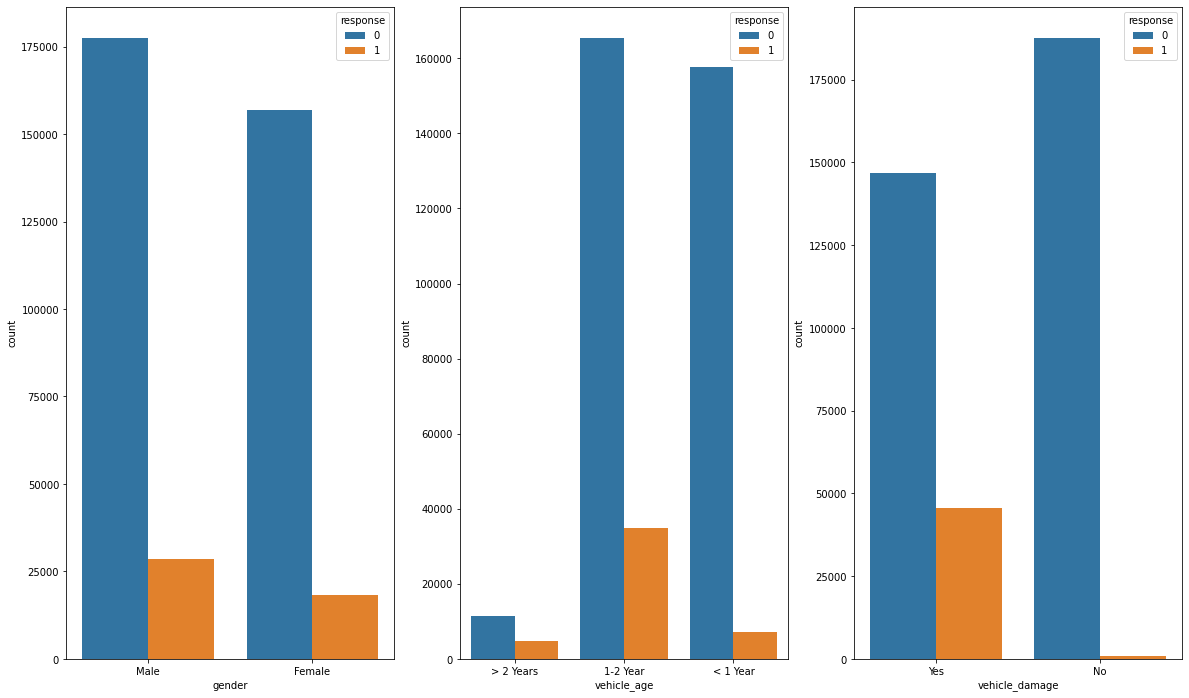

In [15]:
plt.figure(figsize = (20,12))

plt.subplot(1, 3, 1)
sns.countplot(x = "gender", hue ="response" , data = df1)

plt.subplot(1, 3, 2)
sns.countplot(x = "vehicle_age", hue = "response", data = df1)

plt.subplot(1, 3, 3)
sns.countplot(x = "vehicle_damage", hue = "response", data = df1)

# 2.0. Extraindo Recursos

In [16]:
df2 = df1.copy()

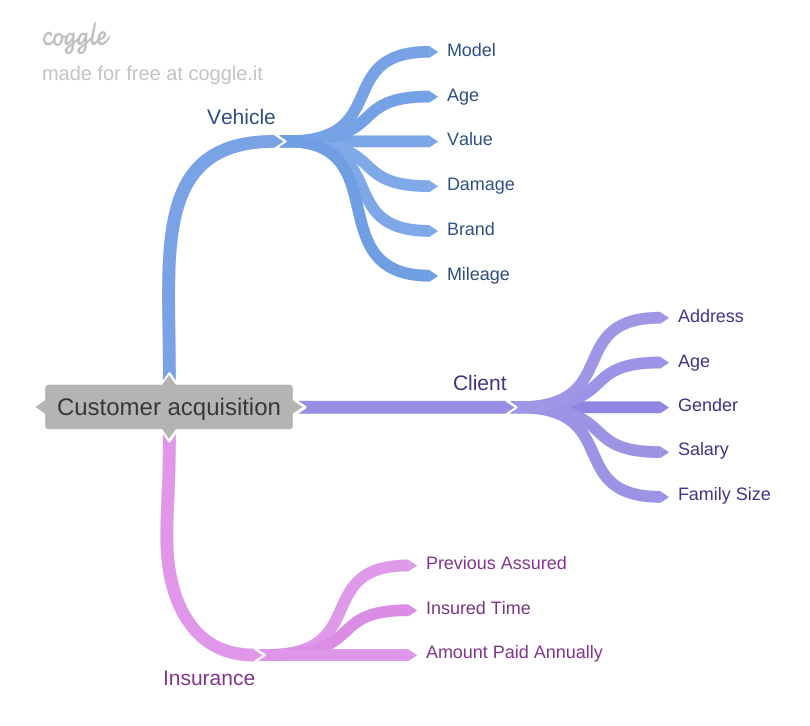

In [17]:
 Image("MindMapHypotesis.png")

 ## 2.1 Hipóteses

**1.** Clientes com veículos menos de 2 anos tem maiores chances de adquirirem um seguro de automóvel.

**2.** Clientes que possuem veículo mais caro tem maiores chances de obterem um seguro de automóvel.

**3.** Clientes com veículos mais populares tem menos chances de obterem um seguro de automóvel.

**4.** Clientes que possuem veículos com menor quilometragem possuem maiores chances de terem um seguro de automóvel.

**5.** Clientes que já tiveram seu veículo danificado tem maiores chances de adquirirem seguro de automóvel.

**6.** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**7.** Clientes que já tem seguro saúde tem maior probabilidade de terem seguro de automóvel.

**8.** Clientes com maiores rendas possuem maiores chances de terem seguro de automóvel.

**9.** Clientes com endereços situados em área nobre possuem maiores chances de terem seguro de automóvel.

**10.** Clientes com mais de 35 anos tem maiores chances de terem seguro de automóvel.

**11.** Clientes que possuem filhos tem maiores chances de terem seguro de automóvel.

**12.** Clientes que pagam mais do que 30500 anualmente pelo seguro saúde tem maiores chances de adquirirem seguro de automóvel.

**13.** Clientes não habilitados tem menores chances de terem seguro de automóvel.


 ## 2.2 Hipóteses que serão testadas:

**1.** Clientes com veículos de menos de 2 anos tem maiores chances de adquirirem um seguro de automóvel.

**2.** ~~Clientes que possuem veículo mais caro tem maiores chances de obterem um seguro de automóvel.~~

**3.** <del>Clientes com veículos mais populares tem menos chances de obterem um seguro de automóvel.<del>

**4.** <del>Clientes que possuem veículos com menor quilometragem possuem maiores chances de terem um seguro de automóvel.<del>

**5.** Clientes que já tiveram seu veículo danificado tem maiores chances de adquirirem seguro de automóvel.

**6.** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**7.** Clientes que já tem seguro saúde tem maior probabilidade de terem seguro de automóvel.

**8.** <del>Clientes com maiores rendas possuem maiores chances de terem seguro de automóvel.<del>

**9.** <del>Clientes com endereços situados em área nobre possuem maiores chances de terem seguro de automóvel.<del>

**10.** Clientes mais de 35 anos tem maiores chances de terem seguro de automóvel.

**11.** <del>Clientes que possuem filhos tem maiores chances de terem seguro de automóvel.<del>

**12.** Clientes que pagam mais do que 30500 anualmente pelo seguro saúde tem maiores chances de adquirirem seguro de automóvel.
    
**13.** Clientes não habilitados tem menores chances de terem seguro de automóvel.


 ### 2.2.1 Hipóteses Finais

**1.** Clientes com veículos de menos de 2 anos tem maiores chances de adquirirem um seguro de automóvel.

**2.** Clientes que já tiveram seu veículo danificado tem maiores chances de adquirirem seguro de automóvel.

**3.** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**4.** Clientes que já tem seguro saúde tem maior probabilidade de terem seguro de automóvel.

**5.** Clientes mais de 35 anos tem maiores chances de terem seguro de automóvel.

**6.** Clientes que pagam mais do que 30500 anualmente pelo seguro saúde tem maiores chances de adquirirem seguro de automóvel.
    
**7.** Clientes não habilitados tem menores chances de terem seguro de automóvel.


In [18]:
df2['v_damage_int'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['v_age_int'] = df2['vehicle_age'].apply(lambda x: 2 if x == '> 2 Years' else 1 if x == '1-2 Year' else 0 )

df2['age_subgroup'] = df2['age'].apply(lambda x: 1 if (x < 35) else 2)

df2['annual_premium_subgroup'] = df2['annual_premium'].apply(lambda x: 'pouco' if x< 24405 else 
                                                                       'medio' if (x > 24405 and x < 31669) else
                                                                       'alto')

In [19]:
cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'v_damage_int',
       'age_subgroup', 'v_age_int', 'annual_premium_subgroup', 'response']

In [20]:
df2 = df2[cols]

In [21]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,v_damage_int,age_subgroup,v_age_int,annual_premium_subgroup,response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454.0,26,217,1,2,2,alto,1
1,2,Male,76,1,3,0,1-2 Year,No,33536.0,26,183,0,2,1,alto,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294.0,26,27,1,2,2,alto,1
3,4,Male,21,1,11,1,< 1 Year,No,28619.0,152,203,0,1,0,medio,0
4,5,Female,29,1,41,1,< 1 Year,No,27496.0,152,39,0,1,0,medio,0


# 3.0. Filtrando Dados

In [22]:
df3 = df2.copy()

# 4.0. Análise Exploratória de Dados

In [23]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Variável Numérica

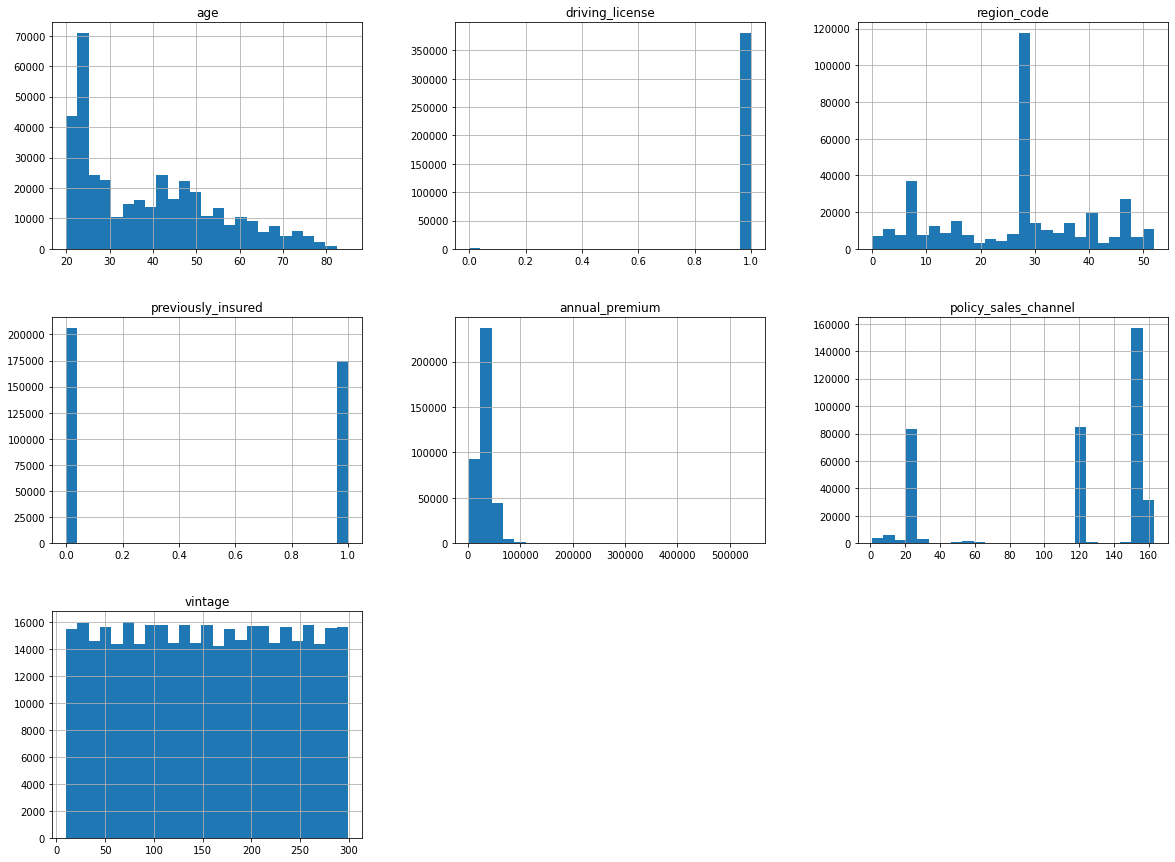

In [24]:
num_attributes.drop(['id', 'response'], axis = 1).hist(figsize = (20,15), bins = 25);

### 4.1.1.1. Age

<AxesSubplot:xlabel='response', ylabel='age'>

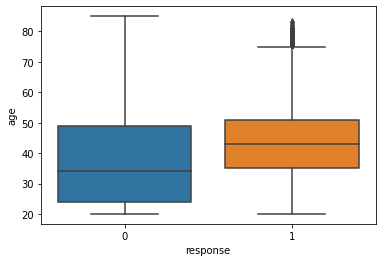

In [25]:
sns.boxplot(x = 'response', y = 'age', data = df4)

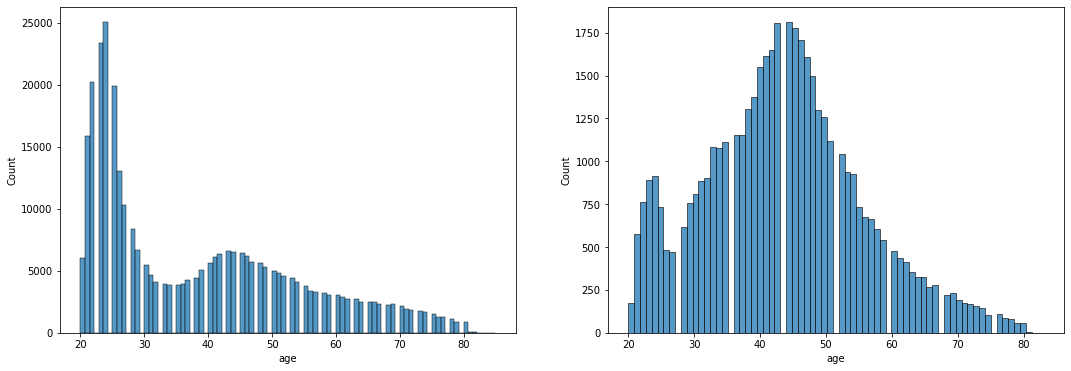

In [26]:
plt.figure(figsize = (18,6))

plt.subplot(1,2, 1)
aux_r0 = df4.loc[df4['response']==0, 'age' ]
sns.histplot(aux_r0);

plt.subplot(1,2, 2)
aux_r1 = df4.loc[df4['response']==1, 'age' ]
sns.histplot(aux_r1);

### 4.1.1.2. Driving License

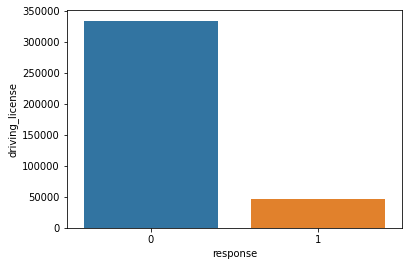

In [27]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.1.3. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

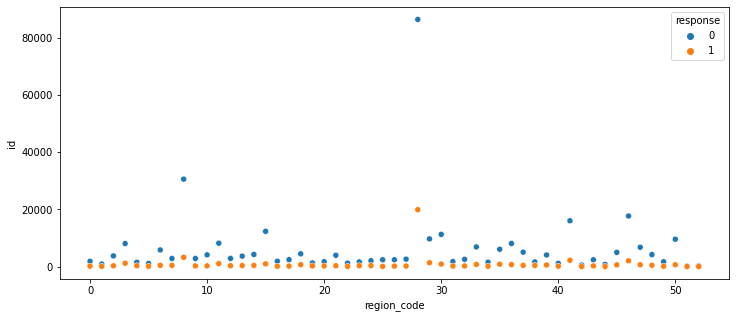

In [28]:
plt.figure(figsize = (12,5))
aux_rc = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x= 'region_code', y='id', hue='response', data=aux_rc)

### 4.1.1.4. Annual Premium

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

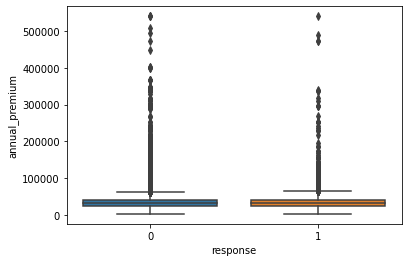

In [29]:
sns.boxplot(y = 'annual_premium', x = 'response', data = df4)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

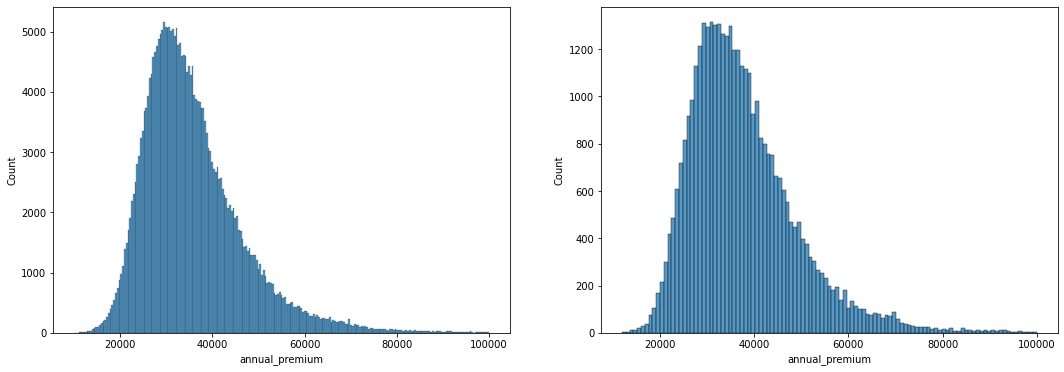

In [30]:
plt.figure(figsize = (18,6))

plt.subplot(1,2, 1)

ax12 = df4[(df4['annual_premium']<100000) & (df4['annual_premium']>10000)]
aux00 = ax12.loc[ax12['response'] == 0, 'annual_premium']
sns.histplot(aux00)

plt.subplot(1,2, 2)

ax13 = df4[(df4['annual_premium']<100000) & (df4['annual_premium']>10000)]
aux01 = ax13.loc[ax13['response'] == 1, 'annual_premium']
sns.histplot(aux01)

### 4.1.1.5. Policy Sales Channel

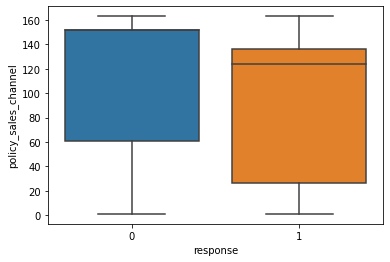

In [31]:
sns.boxplot(x = 'response', y = 'policy_sales_channel', data = df4);

In [32]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux.head()

,policy_sales_channel,response,total_responses
0,1,35,1074
1,2,1,4
2,3,159,523
3,4,102,509
4,6,0,3


### 4.1.1.6. Vintage

<AxesSubplot:xlabel='response', ylabel='vintage'>

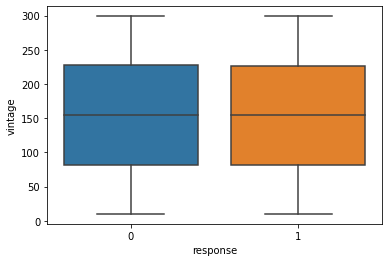

In [33]:
sns.boxplot(x = 'response', y = 'vintage', data = df4)

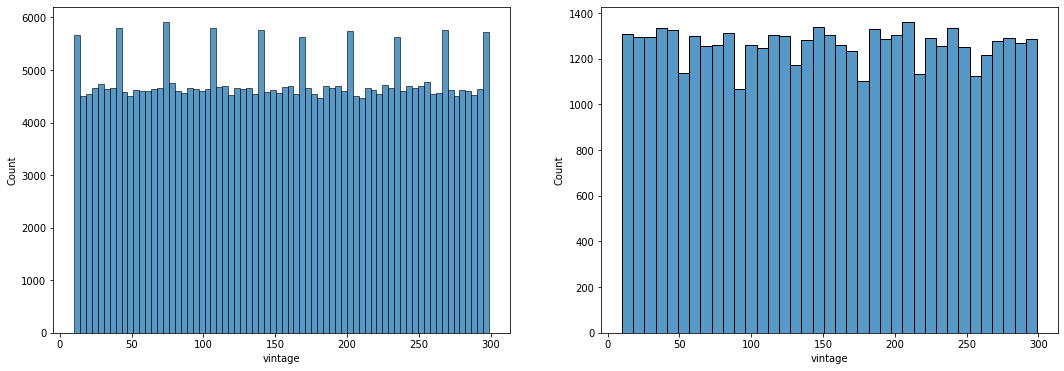

In [34]:
plt.figure(figsize = (18,6))

plt.subplot(1,2, 1)
aux_v0 = df4.loc[df4['response']==0, 'vintage' ]
sns.histplot(aux_v0);

plt.subplot(1,2, 2)
aux_v1 = df4.loc[df4['response']==1, 'vintage' ]
sns.histplot(aux_v1);

### 4.1.2 Variável Categórica

In [35]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


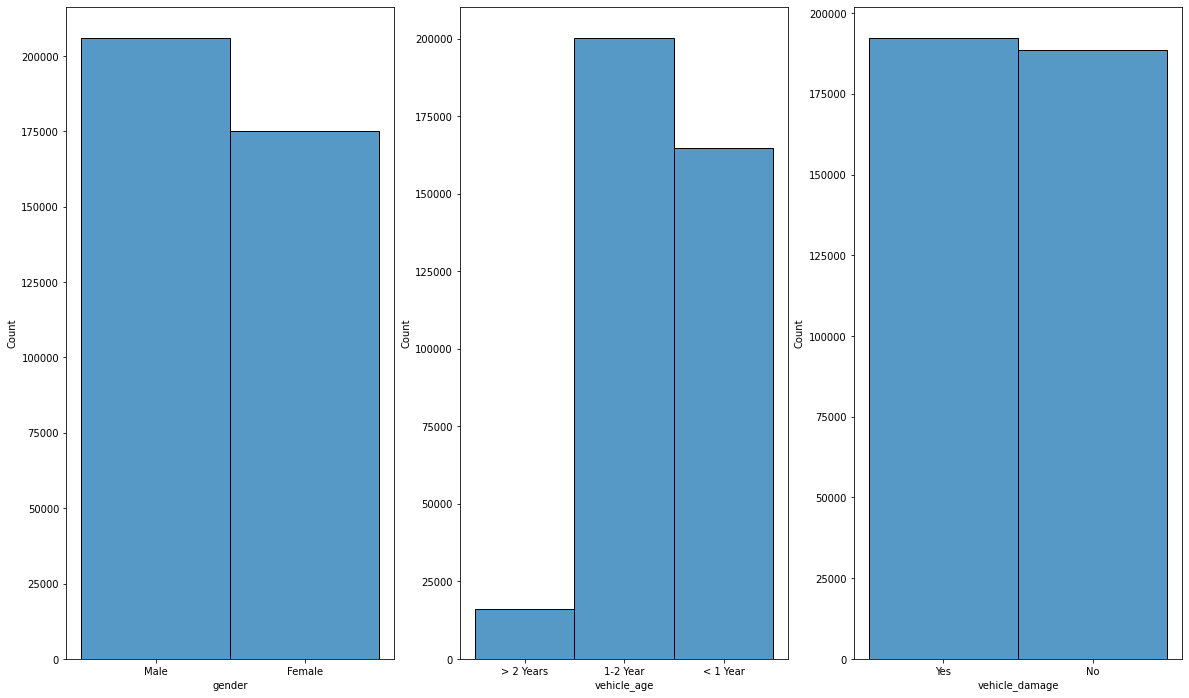

In [36]:
 plt.figure(figsize=(20, 12))


plt.subplot(1, 3, 1)
sns.histplot(data=cat_attributes, x='gender');

plt.subplot(1, 3, 2)
sns.histplot(data=cat_attributes, x='vehicle_age');

plt.subplot(1, 3, 3)
sns.histplot(data=cat_attributes, x='vehicle_damage');

### Gender

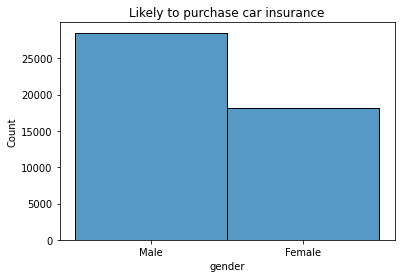

In [37]:
aux_g1 = df4.loc[df4['response'] == 1, 'gender']
sns.histplot( data = aux_g1)
plt.title('Likely to purchase car insurance');


### Vehicle Age

In [38]:
df4[[ 'id','vehicle_age', 'response']].groupby(['response', 'vehicle_age']).count().reset_index()

,response,vehicle_age,id
0,0,1-2 Year,165510
1,0,< 1 Year,157584
2,0,> 2 Years,11305
3,1,1-2 Year,34806
4,1,< 1 Year,7202
5,1,> 2 Years,4702


### Vehicle Damage

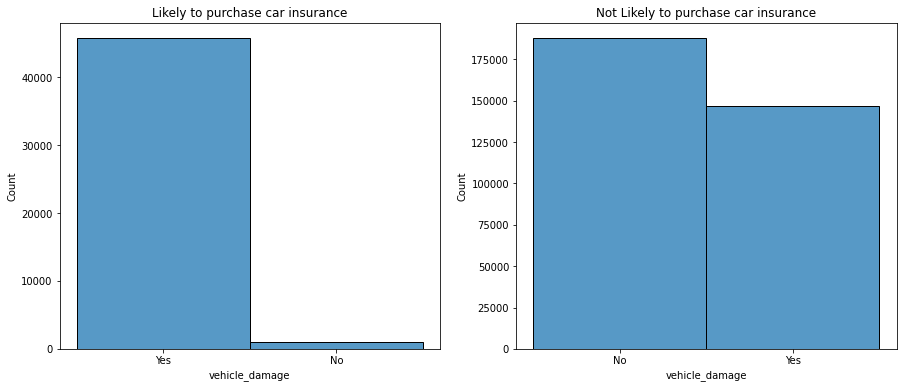

In [39]:
aux_vd1 = df4.loc[df4['response']==1, 'vehicle_damage']
aux_vd0 = df4.loc[df4['response']==0, 'vehicle_damage']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(aux_vd1)
plt.title('Likely to purchase car insurance');

plt.subplot(1,2,2)
sns.histplot(aux_vd0)
plt.title('Not Likely to purchase car insurance');

- Tem-se mais homens;

- O maior número de carros são de carros com até dois anos;

- Tem-se uma maior quantidade de carros que já sofreram danos.

### Response Variable

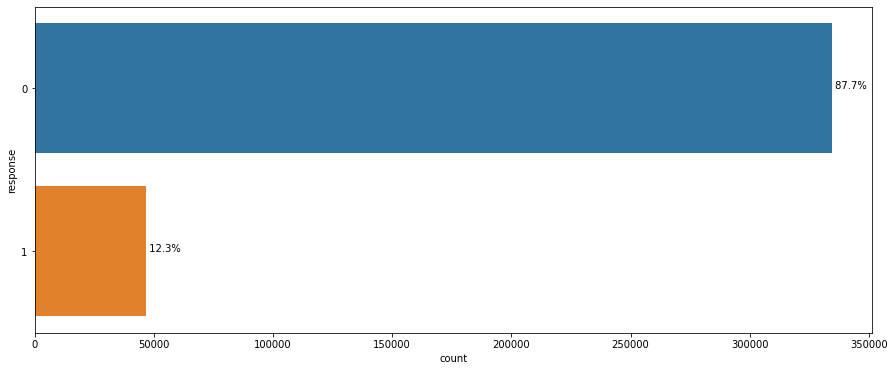

In [40]:
plt.figure(figsize=(15,6))

ax = sns.countplot(y='response', data=df4)

total = df4['response'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

##  4.2 Análise Bivariada

### 4.2.1 Testando Hipóteses

In [41]:
df4_resp1 = df4[df4['response']==1].reset_index()

**1.** Clientes com veículos de menos de 2 anos tem maiores chances de adquirirem um seguro de automóvel.


**Verdadeiro:** De fato clientes portadores de automóveis com menos de dois anos de uso tendem a terem maiores chances de obterem um seguro de automóvel.

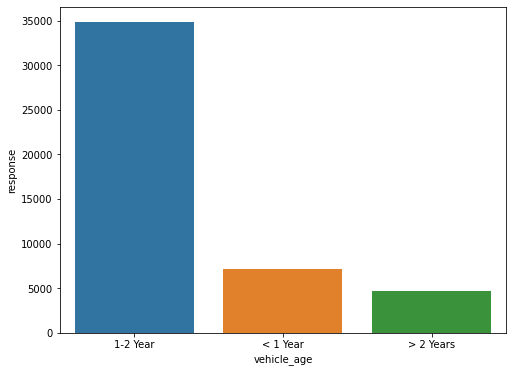

In [42]:
plt.figure(figsize=(8,6))
aux1 = df4_resp1[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x = 'vehicle_age', y = 'response', data = aux1);

**2.** Clientes que já tiveram seu veículo danificado tem maiores chances de adquirirem seguro de automóvel.


**Verdadeiro:** Conforme exposto no gráfico abaixo, clientes cujos automóveis ja sofreram algum dano tendem ser maior número na hora de adquirirem um seguro automotivo.

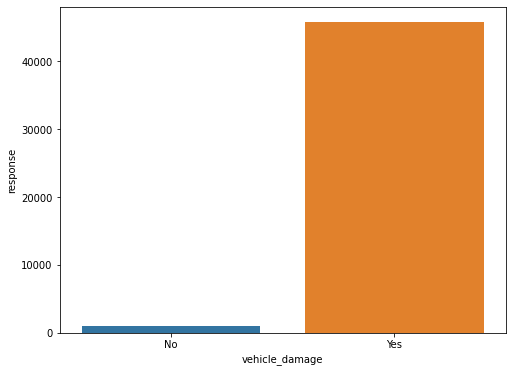

In [43]:
plt.figure(figsize=(8,6))
aux2 = df4_resp1[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()
sns.barplot(y = 'response', x = 'vehicle_damage', data = aux2);

**3.** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**Falso:** Nossa base de dados mostra que são os homens quem mais adquirem seguros automotivos.

<AxesSubplot:xlabel='gender', ylabel='response'>

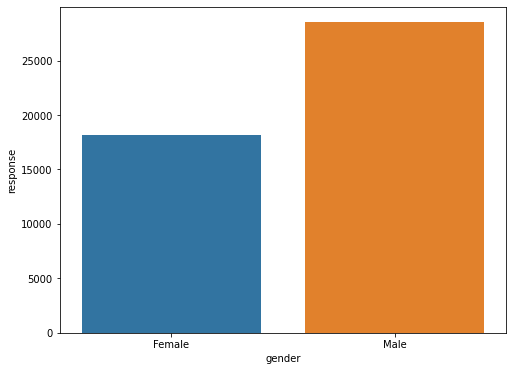

In [44]:
plt.figure(figsize=(8,6))
aux3 = df4_resp1[['gender', 'response']].groupby('gender').sum().reset_index()
sns.barplot(y = 'response', x = 'gender', data = aux3)

**4.** Clientes que já tem seguro saúde tem maior probabilidade de terem seguro de automóvel.

**Falso** Clientes que não tem seguro prévio tem maior probabilidade de adiquirirem um seguro de automóvel

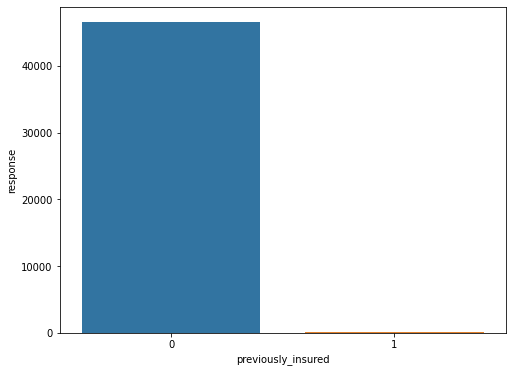

In [45]:
plt.figure(figsize=(8,6))
aux4 = df4_resp1[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()
sns.barplot(x = 'previously_insured', y = 'response', data = aux4);

**5.** Clientes mais de 35 anos tem maiores chances de terem seguro de automóvel.

**Verdadeiro:** De fato nossa base de dados revela que clientes acima de 35 anos tem maior probabilidade de adquirirem um seguro automotivo.

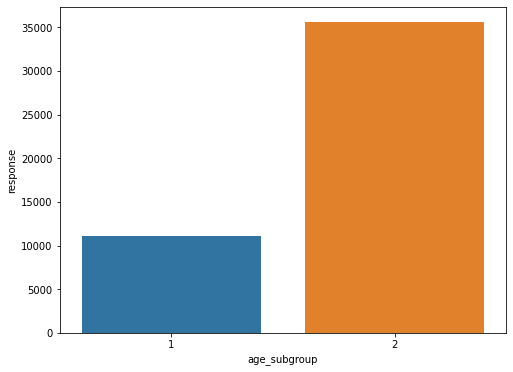

In [46]:
# 1 = Idade menor do que 35 anos 
# 2 = Idade maior do que ou igual a 35 anos
plt.figure(figsize=(8,6))
aux5 = df4_resp1[['age_subgroup', 'response']].groupby('age_subgroup').sum().reset_index()
sns.barplot(x = 'age_subgroup', y = 'response', data = aux5);

**6.** Clientes que pagam mais do que 30500 anualmente pelo seguro saúde tem maiores chances de adquirirem seguro de automóvel.

**Verdaeiro:** Quem paga mais do que 30500('alto') tem uma maior tendencia a adquirir um seguro altomotivo.

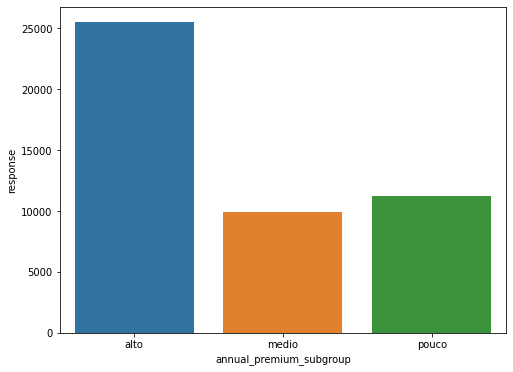

In [47]:
plt.figure(figsize=(8,6))
aux6 = df4_resp1[['annual_premium_subgroup', 'response']].groupby('annual_premium_subgroup').sum().reset_index()
sns.barplot(x = 'annual_premium_subgroup', y = 'response', data = aux6);

**7.** Clientes não habilitados tem menores chances de terem seguro de automóvel.

**Verdadeiro**

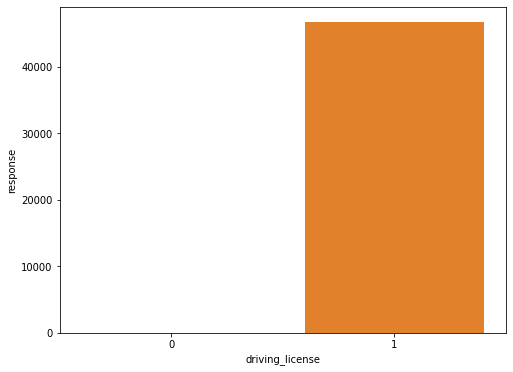

In [48]:
plt.figure(figsize=(8,6))
aux7 = df4_resp1[['driving_license', 'response']].groupby('driving_license').sum().reset_index()
sns.barplot(x = 'driving_license', y = 'response', data = aux7);

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

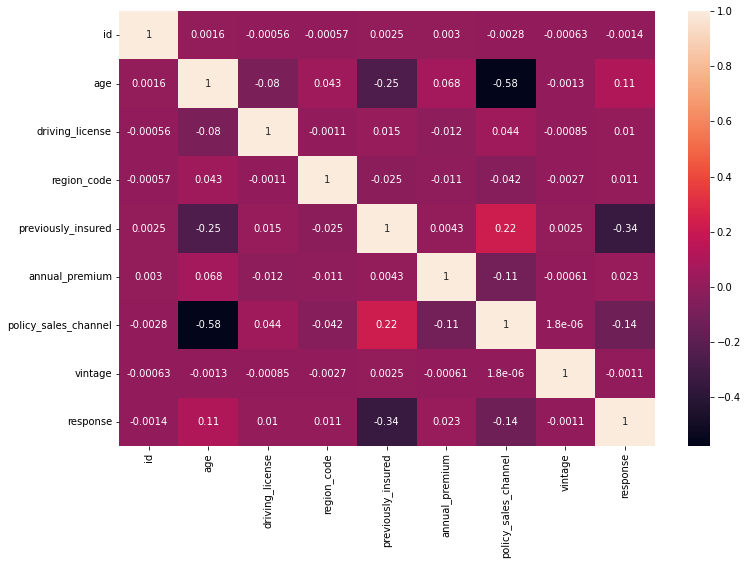

In [49]:
correlation = num_attributes.corr(method = 'pearson')
plt.figure(figsize=(12,8))
sns.heatmap(correlation, annot = True);

### 4.3.2 Variáveis Categóricas

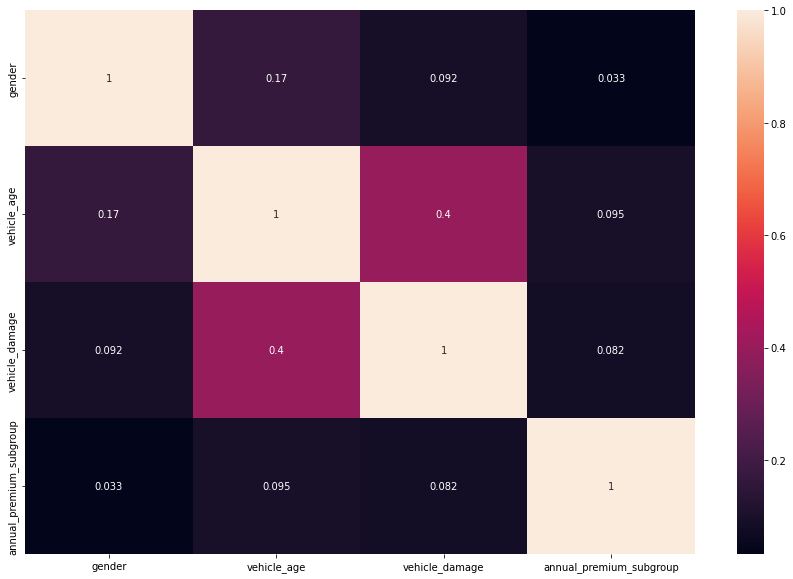

In [50]:
a = df4.select_dtypes(include = 'object')
acols = a.columns

d = defaultdict(list) 

for x,y in product(acols, repeat = 2):
    d[x].append(cramer_v(a[x], a[y]))
    
    
a = pd.DataFrame(d, index=acols)
plt.figure(figsize=(15,10))
sns.heatmap(a, annot=True);

#  5.0. Preparando Dados

In [51]:
X = df4.drop( ['response'], axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [52]:
a = df5.select_dtypes(include = ['int64', 'float64'])
a = a.drop(columns = ['id','v_damage_int','age_subgroup', 'v_age_int','response' ], axis = 1)

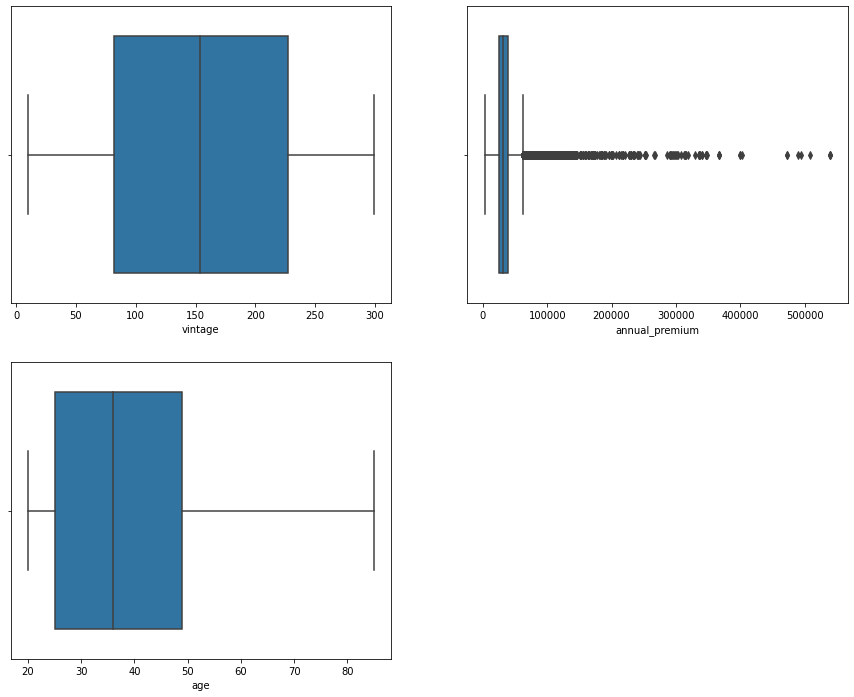

In [53]:
# Plotando o boxplot dos atributos para verificar outliers
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.boxplot(x = a['vintage']);

plt.subplot(2,2,2)
sns.boxplot(x = a['annual_premium']);

#plt.subplot(2,2,3)
#sns.boxplot(x = a['region_code']);

plt.subplot(2,2,3)
sns.boxplot(x = a['age']);

- Observemos que como não temos outliers no atributos: 'vintage' e 'age', podemos instanciar essas variáveis com o MinMaxScaler.
- Já com 'annual_premium' é preferível optar pelo RobustScaler pela quantidade de outlier do atributo. 

## 5.1. Standardization

## 5.2. Redimensionando

In [54]:
# Instanciando o Modelo
rs = RobustScaler()
mms = MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms.fit_transform(df5[['age']].values)
###pickle.dump( mms, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Region_code - MinMaxScaler
df5['region_code'] = mms.fit_transform(df5[['region_code']].values)
###pickle.dump( mms, open( '../src/features/region_code_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)
pickle.dump( mms, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

# Annual_premium - RobustScaler
df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)
###pickle.dump( rs, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )


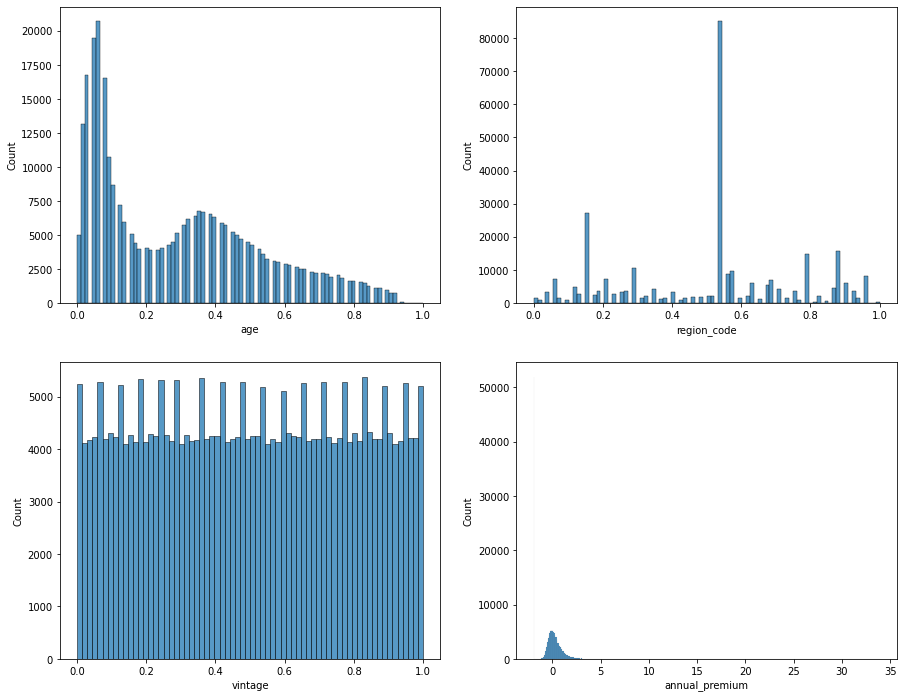

In [55]:
# Plotando os atributos após o processo de Standardization

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.histplot( df5['age']);

plt.subplot(2,2,2)
sns.histplot(df5['region_code']);

plt.subplot(2,2,3)
sns.histplot( df5['vintage']); 

plt.subplot(2,2,4)
sns.histplot(df5['annual_premium']); 

## 5.3. Transformação

### 5.3.1. Encoding

In [56]:
# vehicle_damage - Label Encoding 
binary_map = {'No': 0, 'Yes':1}
df5['vehicle_damage'] = df5['vehicle_damage'].map(binary_map)

# gender - Label Encoding 
df5['gender'] = df5['gender'].apply(lambda x: 0 if x =='Male' else 1)

# vehicle_ age - One Hot/Dummy Encoding
df5 = pd.get_dummies(df5, columns = ['vehicle_age'], prefix = ['vehicle_age'])

#Frequency Encoding

# Region_code and Policy_sales_channel
fe_region_code = (df5.groupby('region_code').size())/len(df5)
fe_policy_sales_channel = (df5.groupby('policy_sales_channel').size())/len(df5)

df5['region_code'] = df5['region_code'].apply(lambda x : fe_region_code[x])
df5['policy_sales_channel'] = df5['policy_sales_channel'].apply(lambda x : fe_policy_sales_channel[x])

# Apagando colunas que não serão mais utilizadas
df5 = df5.drop(columns = ['v_damage_int','age_subgroup', 'annual_premium_subgroup', 'v_age_int'], axis = 1)


In [57]:
# Reordenando colunas
n_cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage',
       'vehicle_age_1-2 Year', 'vehicle_age_< 1 Year',
       'vehicle_age_> 2 Years','response']

df5 = df5[n_cols]

### 5.3.2. Preparação de validação

In [58]:
# Age - MinMaxScaler
x_validation.loc[:,'age'] = mms.fit_transform(x_validation[['age']].values);

# Region_code - MinMaxScaler
x_validation.loc[:,'region_code'] = mms.fit_transform(x_validation[['region_code']].values);

# Vintage - MinMaxScaler
x_validation.loc[:,'vintage'] = mms.fit_transform(x_validation[['vintage']].values);

# Annual_premium - RobustScaler
x_validation.loc[:,'annual_premium'] = rs.fit_transform(x_validation[['annual_premium']].values);

# vehicle_damage - Label Encoding 
binary_map = {'No': 0, 'Yes':1}
x_validation.loc[:,'vehicle_damage'] = x_validation.loc[:,'vehicle_damage'].map(binary_map);

# gender - Label Encoding 
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].apply(lambda x: 0 if x =='Male' else 1);

# vehicle_ age - One Hot/Dummy Encoding
x_validation = pd.get_dummies(x_validation, columns = ['vehicle_age'], prefix = ['vehicle_age']);


#Frequency Encoding

# Region_code and Policy_sales_channel

x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(fe_region_code)
x_validation.loc[:,'policy_sales_channel'] = x_validation.loc[:,'policy_sales_channel'].map(fe_policy_sales_channel)

x_validation = x_validation.fillna(0);


# Apagando colunas que não serão mais utilizadas
x_validation = x_validation.drop(columns = ['v_damage_int','age_subgroup', 'annual_premium_subgroup', 'v_age_int'], axis = 1);


# Reordenando colunas
n_cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage',
       'vehicle_age_1-2 Year', 'vehicle_age_< 1 Year',
       'vehicle_age_> 2 Years']

x_validation = x_validation[n_cols];

# 6.0. Feature Selection

In [59]:
df6 = df5.copy()
df6.shape

(304887, 14)

## 6.1. Feature Importance

In [60]:
forest = en.ExtraTreesClassifier(n_estimators=250, random_state = 0, n_jobs = -1)

# data preparation
x_train_n = df6.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                 feature  importance
0                vintage    0.274505
0         annual_premium    0.245941
0                    age    0.168340
0            region_code    0.097597
0         vehicle_damage    0.071132
0   policy_sales_channel    0.060874
0     previously_insured    0.053453
0   vehicle_age_< 1 Year    0.014201
0   vehicle_age_1-2 Year    0.006434
0                 gender    0.004750
0  vehicle_age_> 2 Years    0.002255
0        driving_license    0.000518


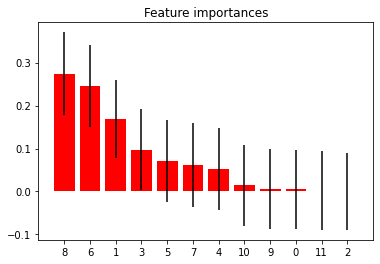

In [61]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 1)
indices = np.argsort(importances)[::-1]

# Print the features ranking

print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
    df = pd.concat([df, aux], axis = 0)
    
print(df.sort_values('importance', ascending = False))

# Plot the impurity-based feature importance os the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color = "r", yerr = std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


**- Conclusão**

Após o processo de seleção de Features através do Boruta, do Feature Importance e da Análise exploratória de Dados.É possível concluir nesse primeiro ciclo que as features mais relevantes para o nosso modelo são:

- vintage   
- annual_premium   
- age    
- region_code    
- vehicle_damage    
- policy_sales_channel  
- previously_insured

# 7.0. Modelos de Machine Learning 

In [62]:
cols_relevant = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [63]:
x_train = df6[ cols_relevant ]

x_val = x_validation[ cols_relevant ]
y_val = y_validation

## 7.1 Random Forest

In [64]:
# Model Definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs = -1, random_state = 7)

# Model Training
rf.fit(x_train, y_train)

# Model Prediction proba
yhat_rf = rf.predict_proba(x_val)

#predict
yhat_randomf = rf.predict( x_val )


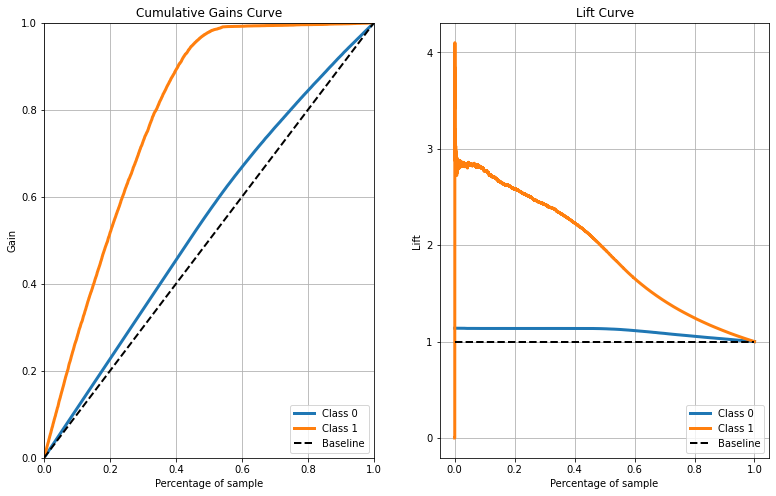

In [65]:
pfig, axs = plt.subplots(ncols= 2, figsize = (13,8))
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax = axs[0]);

#Lift Curve
skplt.metrics.plot_lift_curve( y_val, yhat_rf, ax = axs[1] );

In [66]:
x_validation['response'] = y_validation
precision_rf = round(precision_at_k(x_validation, yhat_rf, 0.20),3)
recall_rf= round(recall_at_k(x_validation, yhat_rf, 0.20),3)
f1_rf = round(2*(precision_rf*recall_rf)/(precision_rf+recall_rf),3)
roc_rf = round(metrics.roc_auc_score(y_validation,yhat_rf[:,1]),3)

print("Precision at k: {}" .format(precision_rf))
print("Recall at k: {}" .format(recall_rf))
print("F1-Score at k {}".format(f1_rf))
print("ROC AUC Score {}".format(roc_rf))


Precision at k: 0.315
Recall at k: 0.517
F1-Score at k 0.391
ROC AUC Score 0.83


## 7.2 Logistic Regression

In [67]:
# Model Definition
lr = lm.LogisticRegression(random_state = 7)

# Model Training
lr.fit(x_train, y_train)

# Model Prediction
yhat_lr = lr.predict_proba(x_val)

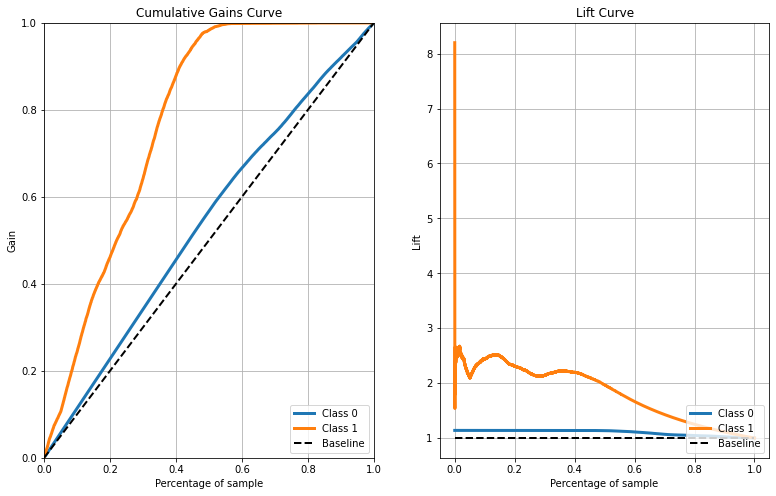

In [68]:
pfig, axs = plt.subplots(ncols= 2, figsize = (13,8))
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax = axs[0]);

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax = axs[1]);

In [69]:
x_validation['response'] = y_validation
precision_lr = round(precision_at_k(x_validation, yhat_lr, 0.20),3)
recall_lr= round(recall_at_k(x_validation, yhat_lr, 0.20),3)
f1_lr = round(2*(precision_lr*recall_lr)/(precision_lr+recall_lr),3)
roc_lr = round(metrics.roc_auc_score(y_validation,yhat_lr[:,1]),3)

print("Precision at k: {}" .format(precision_lr))
print("Recall at k: {}" .format(recall_lr))
print("F1-Score at k {}".format(f1_lr))
print("ROC AUC Score {}".format(roc_lr))

Precision at k: 0.281
Recall at k: 0.461
F1-Score at k 0.349
ROC AUC Score 0.811


## 7.3. XGBoost Classifier

In [70]:
# Model Definition
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', use_label_encoder = False)

# Model Training
xgb_model.fit(x_train, y_train)

# Model Prediction
yhat_xgb = xgb_model.predict_proba(x_val);

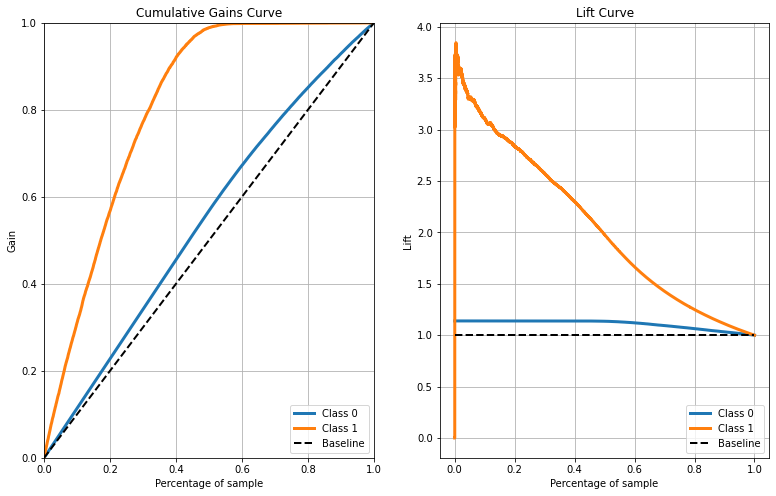

In [71]:
pfig, axs = plt.subplots(ncols= 2, figsize = (13,8))
# Cumularive Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax = axs[0]);

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax = axs[1]);

In [72]:
x_validation['response'] = y_validation
precision_xgb = round(precision_at_k(x_validation, yhat_xgb, 0.20),3)
recall_xgb= round(recall_at_k(x_validation, yhat_xgb, 0.20),3)
f1_xgb = round(2*(precision_xgb*recall_xgb)/(precision_xgb+recall_xgb),3)
roc_xgb = round(metrics.roc_auc_score(y_validation,yhat_xgb[:,1]),3)

print("Precision at k: {}" .format(precision_xgb))
print("Recall at k: {}" .format(recall_xgb))
print("F1-Score at k {}".format(f1_xgb))
print("ROC AUC Score {}".format(roc_xgb))

Precision at k: 0.346
Recall at k: 0.567
F1-Score at k 0.43
ROC AUC Score 0.851


## 7.4. Light Gradient Boosting Machine Classifier

In [73]:
# Model Definition
lgbm_model = LGBMClassifier()

# Model Training
lgbm_model.fit(x_train, y_train)

# Model Prediction
yhat_lgbm = lgbm_model.predict_proba(x_val)

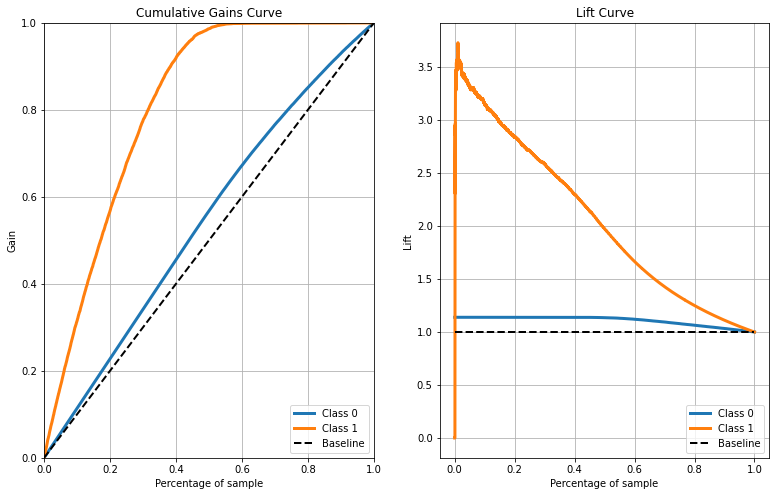

In [74]:
pfig, axs = plt.subplots(ncols= 2, figsize = (13,8))
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm, ax = axs[0]);

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm, ax = axs[1]);


In [75]:
x_validation['response'] = y_validation
precision_lgbm = round(precision_at_k(x_validation, yhat_lgbm, 0.20),3)
recall_lgbm= round(recall_at_k(x_validation, yhat_lgbm, 0.20),3)
f1_lgbm = round(2*(precision_lgbm*recall_lgbm)/(precision_lgbm+recall_lgbm),3)
roc_lgbm = round(metrics.roc_auc_score(y_validation,yhat_lgbm[:,1]),3)

print("Precision at k: {}" .format(precision_lgbm))
print("Recall at k: {}" .format(recall_lgbm))
print("F1-Score at k {}".format(f1_lgbm))
print("ROC AUC Score {}".format(roc_lgbm))

Precision at k: 0.346
Recall at k: 0.568
F1-Score at k 0.43
ROC AUC Score 0.852


## 7.5. K Neighbors Classifier model

In [76]:
# Model Definition
knn_model = KNeighborsClassifier(n_jobs = -1)
# Model training
knn_model.fit(x_train, y_train)
# Model Prediction
yhat_knn = knn_model.predict_proba(x_val)

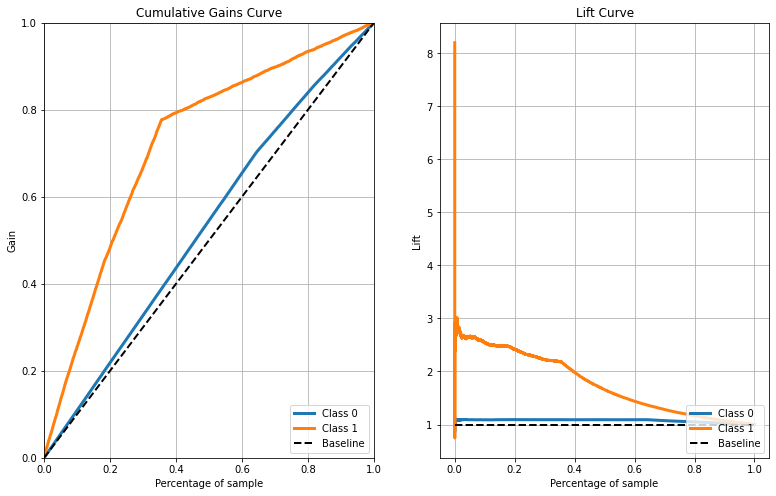

In [77]:
pfig, axs = plt.subplots(ncols= 2, figsize = (13,8))
# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax = axs[0]);

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax = axs[1]);

In [78]:
x_validation['response'] = y_validation
precision_knn = round(precision_at_k(x_validation, yhat_knn, 0.20),3)
recall_knn= round(recall_at_k(x_validation, yhat_knn, 0.20),3)
f1_knn = round(2*(precision_knn*recall_knn)/(precision_knn+recall_knn),3)
roc_knn = round(metrics.roc_auc_score(y_validation,yhat_knn[:,1]),3)

print("Precision at k: {}" .format(precision_knn))
print("Recall at k: {}" .format(recall_knn))
print("F1-Score at k {}".format(f1_knn))
print("ROC AUC Score {}".format(roc_knn))

Precision at k: 0.295
Recall at k: 0.484
F1-Score at k 0.367
ROC AUC Score 0.752


## 7.6. Performance Metrics

In [79]:
models_performance = pd.DataFrame({'Model':['Random Forest'], "Precision_at_k": [precision_rf], "Recall_at_k": [recall_rf], "F1-Score_at_k": [f1_rf], "ROC_AUC_Score": [roc_rf]})

models_performance = models_performance.append(pd.Series(['Logistic Regression',precision_lr, recall_lr, f1_lr, roc_lr], index=models_performance.columns), ignore_index=True)

models_performance = models_performance.append(pd.Series(['XGBoost Classifier', precision_xgb, recall_xgb,f1_xgb, roc_xgb], index=models_performance.columns), ignore_index=True)

models_performance = models_performance.append(pd.Series(['Light Gradient Boosting Machine Classifier', precision_lgbm, recall_lgbm, f1_lgbm, roc_lgbm], index=models_performance.columns), ignore_index=True)

models_performance = models_performance.append(pd.Series(['K Neighbors Classifier', precision_knn, recall_knn, f1_knn, roc_knn], index=models_performance.columns), ignore_index=True)


models_performance

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,Random Forest,0.315,0.517,0.391,0.830
1,Logistic Regression,0.281,0.461,0.349,0.811
2,XGBoost Classifier,0.346,0.567,0.430,0.851
3,Light Gradient Boosting Machine Classifier,0.346,0.568,0.430,0.852
4,K Neighbors Classifier,0.295,0.484,0.367,0.752


## 7.7. Cross Validation

In [80]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [81]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest CV', rf, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Logistic Regression Classifier CV', lr, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier CV', xgb_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier CV', lgbm_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'K Neighbors Classifier', knn_model, x_train, y_train)


In [82]:
models_performance_cv.sort_values('F1-Score_at_k', ascending=False)

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
3,LightGBM Classifier CV,0.3518 +/- 0.0035,0.5734 +/- 0.006,0.4362 +/- 0.0045,0.8548 +/- 0.0017
2,XGBoost Classifier CV,0.3492 +/- 0.0037,0.569 +/- 0.0064,0.4328 +/- 0.0044,0.853 +/- 0.0021
0,Random Forest CV,0.3184 +/- 0.0031,0.5192 +/- 0.0052,0.3946 +/- 0.0038,0.8312 +/- 0.0018
4,K Neighbors Classifier,0.2964 +/- 0.0029,0.4832 +/- 0.0044,0.3672 +/- 0.0036,0.7542 +/- 0.0033
1,Logistic Regression Classifier CV,0.2866 +/- 0.0029,0.4668 +/- 0.0045,0.355 +/- 0.0034,0.8148 +/- 0.0012


### 7.7.1. Understanding metrics in 50% of the database

In [83]:
models_performance_cv50 = pd.DataFrame({'Model':'LightGBM Classifier CV', "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [84]:
x_validation['response'] = y_validation
precision_lgbm50 = round(precision_at_k(x_validation, yhat_lgbm, 0.50),3)
recall_lgbm50= round(recall_at_k(x_validation, yhat_lgbm, 0.50),3)
f1_lgbm50 = round(2*(precision_lgbm*recall_lgbm)/(precision_lgbm+recall_lgbm),3)
roc_lgbm50 = round(metrics.roc_auc_score(y_validation,yhat_lgbm[:,1]),3)

print("Precision at 50: {}" .format(precision_lgbm50))
print("Recall at 50: {}" .format(recall_lgbm50))
print("F1-Score at 50 {}".format(f1_lgbm50))
print("ROC AUC Score {}".format(roc_lgbm50))

Precision at 50: 0.241
Recall at 50: 0.986
F1-Score at 50 0.43
ROC AUC Score 0.852


In [85]:
models_performance_cv_50 = pd.DataFrame({'Model':[], "Precision_at_50": [], "Recall_at_50": [], "F1-Score_at_50": [], "ROC_AUC_Score": []})

In [86]:
models_performance_cv_50 = cross_validation_50(models_performance_cv_50, 5 , 'LightGBM Classifier CV', lgbm_model, x_train, y_train)


In [87]:
models_performance_cv_50

,Model,Precision_at_50,Recall_at_50,F1-Score_at_50,ROC_AUC_Score
0,LightGBM Classifier CV,0.2426 +/- 0.0005,0.9878 +/- 0.001,0.3896 +/- 0.0005,0.8548 +/- 0.0017


# 8.0. Hyperparameter tuning

## 8.1. Light Gradient Boosting Machine Classifier

In [88]:
def tune_lgbm(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_samples = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
              
    #Model
    model = LGBMClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_samples=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5],
                                    random_state=0, n_jobs=-1)

    model.fit(x_train, y_train)

    # Prediction
    yhat = model.predict(x_val)

    # Prediction Proba
    yhat_proba = model.predict_proba(x_val)[:,1]
    
    # Performance
    roc = metrics.roc_auc_score(y_val, yhat_proba)
    
    return -roc

param = [(1e-3, 1e-2, 'log-uniform'), #lr
        (1, 2), #max_depth
        (1, 2), #min_child_samples
        (0.05, 0.5), #subsample
        (0.5, 1), #colsample_bytree
        (100, 500)] #n_estimetors

In [89]:
resultado_dummy_lgbm = dummy_minimize(tune_lgbm, param, n_calls=10, random_state=42)
print("Melhor valor encontrado: {}\nMelhores parametros: {}".format(resultado_dummy_lgbm.fun * -1, resultado_dummy_lgbm.x))

[0.006259548184287541, 1, 1, 0.4008609501227462, 0.7984250789732436, 221]
[0.0014321698289111518, 1, 1, 0.4397792655987209, 0.8005575058716045, 251]
[0.004475983459259065, 1, 2, 0.37489944752007115, 0.9692763545078752, 485]
[0.0015199348301309814, 1, 1, 0.186909009331792, 0.762378215816119, 335]
[0.0010545384637703184, 1, 1, 0.229937437271865, 0.5233328316068078, 287]
[0.002324672848950434, 2, 2, 0.4033291826268562, 0.5998368910791799, 154]
[0.009621236402909397, 1, 1, 0.4369731830313443, 0.8401537692938899, 428]
[0.0011615865989246452, 2, 1, 0.48453441488355176, 0.9041986740582306, 364]
[0.0010374477955901187, 2, 2, 0.15846145971170528, 0.8416317594127292, 363]
[0.0010824018381500955, 2, 1, 0.16645099172000763, 0.8312611421769911, 101]
Melhor valor encontrado: 0.8332105718479726
Melhores parametros: [0.009621236402909397, 1, 1, 0.4369731830313443, 0.8401537692938899, 428]


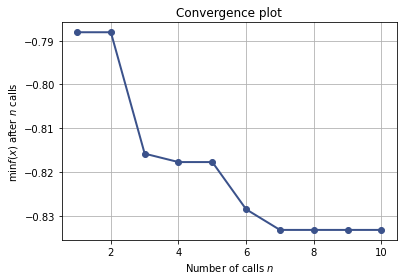

In [90]:
plot_convergence(resultado_dummy_lgbm);

In [91]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier CV', lgbm_model, x_train, y_train)


## 8.4. Cross Validation

In [92]:
lgbm_model_tunned = LGBMClassifier(learning_rate=0.008788031492218835, num_leaves=2 ** 2, max_depth=2, min_child_samples=1,
                                    subsample=0.44023952009975176, colsample_bytree=0.8182017987230057, n_estimators=439,
                                    random_state=0, n_jobs=-1)



In [93]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier Tunned CV', lgbm_model_tunned, x_train, y_train)

In [94]:
models_performance_cv.sort_values('F1-Score_at_k', ascending = False)

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
3,LightGBM Classifier CV,0.3518 +/- 0.0035,0.5734 +/- 0.006,0.4362 +/- 0.0045,0.8548 +/- 0.0017
5,LightGBM Classifier CV,0.3518 +/- 0.0035,0.5734 +/- 0.006,0.4362 +/- 0.0045,0.8548 +/- 0.0017
2,XGBoost Classifier CV,0.3492 +/- 0.0037,0.569 +/- 0.0064,0.4328 +/- 0.0044,0.853 +/- 0.0021
6,LightGBM Classifier Tunned CV,0.3386 +/- 0.0022,0.5524 +/- 0.0034,0.42 +/- 0.0026,0.8446 +/- 0.001
0,Random Forest CV,0.3184 +/- 0.0031,0.5192 +/- 0.0052,0.3946 +/- 0.0038,0.8312 +/- 0.0018
4,K Neighbors Classifier,0.2964 +/- 0.0029,0.4832 +/- 0.0044,0.3672 +/- 0.0036,0.7542 +/- 0.0033
1,Logistic Regression Classifier CV,0.2866 +/- 0.0029,0.4668 +/- 0.0045,0.355 +/- 0.0034,0.8148 +/- 0.0012


### 8.4.1 Result of Tuned Model

In [95]:
models_performance_cv50 = pd.DataFrame({'Model':'LightGBM Classifier CV', "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [96]:
x_validation['response'] = y_validation
precision_lgbm50 = round(precision_at_k(x_validation, yhat_lgbm, 0.50),3)
recall_lgbm50= round(recall_at_k(x_validation, yhat_lgbm, 0.50),3)
f1_lgbm50 = round(2*(precision_lgbm*recall_lgbm)/(precision_lgbm+recall_lgbm),3)
roc_lgbm50 = round(metrics.roc_auc_score(y_validation,yhat_lgbm[:,1]),3)

print("Precision at 50: {}" .format(precision_lgbm50))
print("Recall at 50: {}" .format(recall_lgbm50))
print("F1-Score at 50 {}".format(f1_lgbm50))
print("ROC AUC Score {}".format(roc_lgbm50))

Precision at 50: 0.241
Recall at 50: 0.986
F1-Score at 50 0.43
ROC AUC Score 0.852


In [97]:
models_performance_cv_50 = pd.DataFrame({'Model':[], "Precision_at_50": [], "Recall_at_50": [], "F1-Score_at_50": [], "ROC_AUC_Score": []})

In [98]:
models_performance_cv_50 = cross_validation_50(models_performance_cv_50, 5 ,  'LightGBM Classifier Tunned CV', lgbm_model_tunned, x_train, y_train)


In [99]:
models_performance_cv_50

,Model,Precision_at_50,Recall_at_50,F1-Score_at_50,ROC_AUC_Score
0,LightGBM Classifier Tunned CV,0.2424 +/- 0.0005,0.9872 +/- 0.0012,0.3894 +/- 0.0005,0.8446 +/- 0.001


# 9.0. Conclusões: Assunto de Negócios

**1.Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.**

- Os mais interessados têm entre 40 e 50 anos.

- De acordo com a secção 4.1.2, os homens que possuem um automóvel com período compreendidas entre 1 e 2 anos e que sofreram uma avaria têm mais probabilidades de obter um seguro automóvel.

**2.Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?** 



* A base de dados é baseada em 46.876 (12,3%) clientes interessados ​​em planos de saúde e 334.232 (87,7%) não interessados.
* Os resultados do modelo mostraram que o modelo tem uma precisão de 24,2%. Assim, usando o modelo é possível contatar 4.840 clientes interessados ​​em seguro saúde de 20.000 ligações. No entanto, o recall é de cerca de 98,7% (+/- 0,0006).

**3.E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?**


* Aumentar para 40.000 ligações o modelo pode ajudar a equipe de vendas a contatar 9.680 clientes interessados ​​em planos de saúde.

**4.Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?**

* O modelo classificou 98,7% (46.266 clientes) do cliente interessado em 50% do banco de dados com 381.109 clientes. Com o modelo, é possível contatar 80% dos clientes interessados em planos de saúde em 154.963 ligações (154.963 por desempenho excelente ou 154.963 por desempenho ruim).